# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

This notebook implements a traffic sign classifier trained on [The German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news).

The accuracy achieved is sufficient for real-time use (~97%) while the model complexity allows for usage in real-time scnarios (60-70 FPS) on mobile Android device. The network is deployed using PyTorch mobile, which is described in repository's README.md

## Step 0: Install the prerequisites

To implement the classifier, we will use [fastai](https://docs.fast.ai/) library. It is high-level API built on top of PyTorch that allows to easily build state-of-the-art performance-wise models and simplifies rapid prototyping. Moreover, since the models are built in PyTorch, we will be able to deploy model to mobile device using [PyTorch mobile](https://pytorch.org/mobile/home/). This will allow us to recognize street sign on any modern Android phone in real time!

This notebook was implemented in Google Colab. fastai provides simple installation scripts that prepare the environment with a single line.

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


Now that the library is installed, we import all the modules and configure the notebook to enable visualizations.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

## Step 1: Download & load the data

In [0]:
!wget https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip

--2020-02-25 12:59:14--  https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.24
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘traffic-signs-data.zip’

traffic-signs-data. 100%[===================>] 117.80M  20.0MB/s    in 6.9s    

2020-02-25 12:59:21 (17.2 MB/s) - ‘traffic-signs-data.zip’ saved [123524425/123524425]



In [0]:
!unzip traffic-signs-data.zip

Archive:  traffic-signs-data.zip
  inflating: test.p                  
  inflating: train.p                 
  inflating: valid.p                 


In [0]:
# Uncomment this to download string labels for the GTSRB dataset

!wget https://raw.githubusercontent.com/udacity/CarND-Traffic-Sign-Classifier-Project/a53673bd8bcfccceb47497a11ece4af6cc9af3f3/signnames.csv

--2020-02-25 13:01:01--  https://raw.githubusercontent.com/udacity/CarND-Traffic-Sign-Classifier-Project/a53673bd8bcfccceb47497a11ece4af6cc9af3f3/signnames.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 999 [text/plain]
Saving to: ‘signnames.csv’

signnames.csv       100%[===================>]     999  --.-KB/s    in 0s      

2020-02-25 13:01:01 (78.7 MB/s) - ‘signnames.csv’ saved [999/999]



In [0]:
# Load pickled data
import pickle
import pathlib
import random
import re
import os
from os import path

import cv2

training_file = 'train.p'
validation_file = 'valid.p'
testing_file = 'test.p'
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [303]:
# Print some dataset statistics

n_train = len(X_train)

n_validation = len(X_valid)

n_test = len(X_test)

image_shape = X_train.shape[1:]

n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [0]:
with open('signnames.csv', 'r') as f:
    labels = f.readlines()[1:] # First line is CSV header
labels = [l.split(',')[1][:-1] for l in labels] # Save only text labels, no newline
labels = ['_'.join(l.split(' ')) for l in labels] # Avoid spaces in directory names
labels = [re.sub('[/\(\)]', '', l) for l in labels] # Remove unwanted characters

# Print a couple of processed labels
for n in range(10):
    print(random.choice(labels))

Vehicles_over_3.5_metric_tons_prohibited
Stop
End_of_all_speed_and_passing_limits
Speed_limit_70kmh
No_passing
No_passing_for_vehicles_over_3.5_metric_tons
End_of_no_passing
Roundabout_mandatory
End_of_no_passing_by_vehicles_over_3.5_metric_tons
Speed_limit_70kmh


fastai data loaders expect training data to have particular layout. The following functions process the data for fastai and save it in one of the supported formats.

In [0]:
def mkdir_if_doesnt_exist(dir_path):
    try:
        os.mkdir(dir_path)
    except FileExistsError:
        pass

def create_gtsrb_imagenet_like(data_dir='data'):
    mkdir_if_doesnt_exist(data_dir)
    datasets = {
        'train': (X_train, y_train),
        'valid': (X_valid, y_valid),
        'test': (X_test, y_test)
    }
    dataset_paths = [path.join(data_dir, ds) for ds in datasets]
    for p in dataset_paths:
        mkdir_if_doesnt_exist(p)

    for p, ds in zip(dataset_paths, datasets):
        Xs, ys = datasets[ds]
        for idx, (X, y) in enumerate(zip(Xs, ys)):
            cls_dir = path.join(p, labels[int(y)])
            mkdir_if_doesnt_exist(cls_dir)
            img_path = path.join(cls_dir, '{}.png'.format(idx))
            X_cv = cv2.cvtColor(X, cv2.COLOR_RGB2BGR)
            cv2.imwrite(img_path, X_cv)

In [0]:
create_gtsrb_imagenet_like()

In [0]:
# Load data into fastai and enable some data augumentation to improve generalization
data = ImageDataBunch.from_folder('data', size=32, bs=64,
                                  ds_tfms=get_transforms(max_rotate=25, do_flip=False, max_warp=0.3))
# Normalize with dataset statistics to improve model convergencce
data = data.normalize()

The data is now loaded, let's visualize some examples to make sure everything is correct.

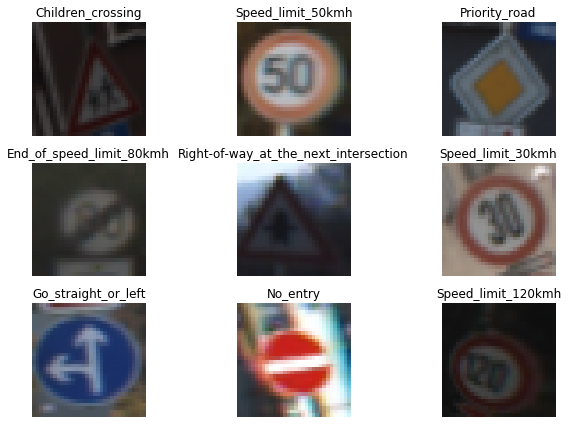

In [0]:
data.show_batch(rows=3, figsize=(8,6))

## Step 2: Build a model

We tested two models.

First model had an architecture inspired by ResNet family of networks. The architecture consisted of 5 blocks, each containing a residual convolutional sub-block and a downsampling convolutional layer. Every downsampling convolutional layer decreased image dimensions by 2, so since input image have dimension 32x32, and 2^5=32, then spatial dimensions after fifth block were 1x1. To avoid information loss, we increased number of channels by a factor of 2 with each downsampling layer. Final layer was a dense layer implemented with 1x1 convolution, which outputed class logits.

We noticed this architecture caused validation loss to randomly peak at large values during training - a sign of overfitting. Sub-par performance led to development of the second model.

Following [Traffic Sign Recognition with Multi-Scale Convolutional Networks](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) I used architecure, in which convolutional layer serve as multi-stage feature extractors. Extracted feature maps are flattened and fed into fully connected classifier layer. We use dropout before that layer to avoid overfitting, which leads to validation loss closely following training loss.

In [0]:
def customConv2d(in_ch, out_ch, kernel=3, stride=1, padding=1, bias=False):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, kernel_size=kernel, stride=stride, padding=padding, bias=bias),
        nn.BatchNorm2d(out_ch),
        nn.ReLU(),
    )

In [0]:
def resnet_like_model(start_out_ch):
    return nn.Sequential(
        customConv2d(3, start_out_ch, kernel=7, stride=2, padding=3),
        res_block(start_out_ch, bottle=False),
        customConv2d(start_out_ch, 2*start_out_ch, stride=2),
        res_block(2*start_out_ch, bottle=False),
        customConv2d(2*start_out_ch, 4*start_out_ch, stride=2),
        res_block(4*start_out_ch, bottle=False),
        customConv2d(4*start_out_ch, 8*start_out_ch, stride=2),
        res_block(8*start_out_ch, bottle=False),
        customConv2d(8*start_out_ch, 16*start_out_ch, stride=2),
        res_block(16*start_out_ch, bottle=False),
        customConv2d(16*start_out_ch, len(set(y_train))),
        Flatten()
    )

In [0]:
# Use this to train resnet_like_model in

# model = resnet_like_model(start_out_ch=16)

In [0]:
class MultiStageModel(torch.nn.Module):
    def __init__(self, start_out_ch):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(MultiStageModel, self).__init__()
        _, im_ch, im_sz, _ = data.one_batch()[0].size()
        # Stage 1 conv layers
        stage1_out_ch = 2*start_out_ch
        stage1_out_sz = im_sz // 4
        self.stage1 = nn.Sequential(
            customConv2d(im_ch, start_out_ch, kernel=7, stride=2, padding=3),
            res_block(start_out_ch, bottle=False),
            customConv2d(start_out_ch, stage1_out_ch, stride=2)
        )
        # Stage 2 conv layers
        stage2_out_ch = 2*stage1_out_ch
        stage2_out_sz = stage1_out_sz // 2
        self.stage2 = nn.Sequential(
            res_block(stage1_out_ch, bottle=False),
            customConv2d(stage1_out_ch, stage2_out_ch, stride=2),
        )
        # Classifier
        dense_in = stage1_out_sz*stage1_out_sz*stage1_out_ch
        dense_in += stage2_out_sz*stage2_out_sz*stage2_out_ch
        self.dropout = nn.Dropout(0.2)
        self.dense = nn.Linear(dense_in, len(data.classes))

    def forward(self, x):
        y1 = self.stage1(x)
        y2 = self.stage2(y1)
        y1_flat = nn.Flatten()(y1)
        y2_flat = nn.Flatten()(y2)
        y = torch.cat((y1_flat, y2_flat), dim=1)
        y = self.dropout(y)
        y = self.dense(y)
        return y

In [0]:
model = MultiStageModel(start_out_ch=32)

## Step 3: Setup fastai Learner, train the model



In [0]:
# We use cross-entropy loss, since this is a classification problem
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [284]:
# Show model architecture
learn.summary()

MultiStageModel
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 16, 16]         4,704      True      
______________________________________________________________________
BatchNorm2d          [32, 16, 16]         64         True      
______________________________________________________________________
ReLU                 [32, 16, 16]         0          False     
______________________________________________________________________
Conv2d               [32, 16, 16]         9,216      True      
______________________________________________________________________
ReLU                 [32, 16, 16]         0          False     
______________________________________________________________________
BatchNorm2d          [32, 16, 16]         64         True      
______________________________________________________________________
Conv2d               [32, 16, 16]         9,216      True      
______________________________________________

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


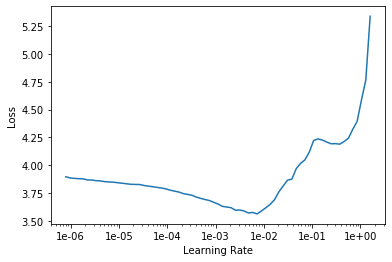

In [285]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

Based on plot, we set learning rate to 3e-3. We train using 1cycle policy for 10 epochs, with batch size equal to 64.

In [286]:
learn.fit_one_cycle(10, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.093397,1.192240,0.685261,01:01
1,0.710918,0.695792,0.803175,01:01
2,0.403566,0.588087,0.871655,01:00
3,0.237506,0.304259,0.934694,01:00
4,0.147152,0.208087,0.955329,01:00
5,0.109972,0.222428,0.954649,01:00
6,0.072598,0.217710,0.963492,01:00
7,0.039556,0.135802,0.975057,01:00
8,0.024519,0.124019,0.978458,01:00
9,0.021574,0.122938,0.980045,01:01


In [288]:
learn.validate()

[0.12293802, tensor(0.9800)]

Accuracy is 98% on validation dataset, pretty nice!

In [287]:
il = ImageList.from_folder(path='data/test')
sd = il.split_none().label_from_folder()
db = sd.databunch().normalize(stats=data.stats)
learn.validate(dl=db.train_dl)

[0.12313732, tensor(0.9726)]

On the test dataset, the accuracy is 97.26%. A little bit worse, but still seems usable.

Evaluation on test dataset shows accuracy of 97.26%. Pretty good but there is room for improvement. Nevertheless, the accuracy provides the network that should be usable in practice. We save the model to deploy it to the mobile app (more on that later).

In [0]:
# fastai format
learn.save('valid-98')

# PyTorch Mobile format
model = model.cpu()
# We want mobile model to output probabilities instead of logits
mobile_model = nn.Sequential(model, nn.Softmax(dim=1)) 
example = torch.rand(1, 3, 32, 32)
traced_script_module = torch.jit.trace(mobile_model, example)
traced_script_module.save("data/models/valid-98-mobile.pt")
model = model.cuda()

## Step 4: Model analysis

We're using fastai ClasssificationInterpretation to visualize model results. It visualizes predictions of the model on validation dataset.

In [290]:
interp = ClassificationInterpretation.from_learner(learn)

First, we plot confusion matrix to detect which classes are the most problematic.

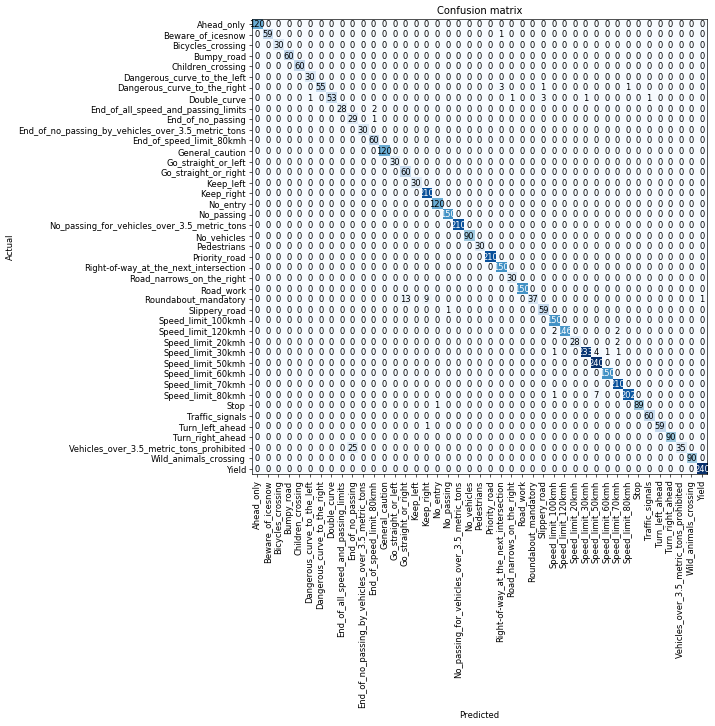

In [291]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

We see 2 peaks on the chart. Firstly, sign for "Vehicles_over_3.5_metric_tons_prohibited" gets confused with "End_of_no_passing". Secondly, "Roundabout_mandatory" is confused with "Go_straight_or_right".

In [296]:
interp.most_confused()[0:5]

[('Vehicles_over_3.5_metric_tons_prohibited', 'End_of_no_passing', 25),
 ('Roundabout_mandatory', 'Go_straight_or_right', 13),
 ('Roundabout_mandatory', 'Keep_right', 9),
 ('Speed_limit_80kmh', 'Speed_limit_50kmh', 7),
 ('Speed_limit_30kmh', 'Speed_limit_50kmh', 4)]

Let's examine predictions for confused examples. First, let's look at the most confused examples.

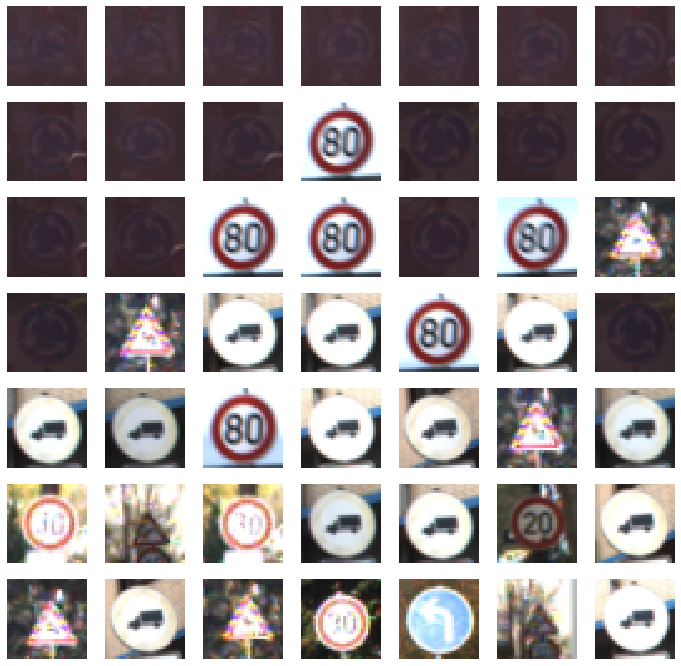

In [297]:
interp.plot_top_losses(k=49, show_text=False)

Above chart contains most of the confused "Roundabout_necessary" signs (18 of them) and majority (13) of confused "Vehicles_over_3.5_metric_tons_prohibited" signs. Let's visualize the signs they were confused with.

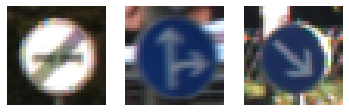

In [300]:
from glob import glob

NO_PASSING = glob('data/train/End_of_no_passing/*.png')
GO_STRAIGHT_OR_RIGHT = glob('data/train/Go_straight_or_right/*.png')
KEEP_RIGHT = glob('data/train/Keep_right/*.png')

sign_lists = [
    NO_PASSING,
    GO_STRAIGHT_OR_RIGHT,
    KEEP_RIGHT
]

to_vis = []
for sign_list in sign_lists:
    img = cv2.imread(random.choice(sign_list))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    to_vis.append(img)

fig, ax = plt.subplots(nrows=1, ncols=3)
for i in range(len(to_vis)):
    ax[i].imshow(to_vis[i])
    ax[i].axis('off')

Notice that most confused examples are really similair - they probably come from the video and contain the same traffic sign.

Confused "Roundabout_necessary" sign is blue and circular. The photo is really dark. Noticed that the confused signs: "Go_straight_or_right" and "Keep_right" are also blue and circular.

Confused "Vehicles_over_3.5_metric_tons_prohibited" sign is circular and black-and-white, same as "End_of_no_passing". Again, it seems that color similarity confuses the network.

A possible idea to improve the accuracy could be to discourage the network from color overfitting by inputting grayscale images instead of the color ones. In [Traffic Sign Recognition with Multi-Scale Convolutional Networks](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) paper it is shown that indeed for GSTRB dataset, it provides non-trivial improvement of score.

## Step 5: Performance of model in real-life scenario

To evaluate the mode in real-life scenario, we:
- Download 5 images with traffic signs from Google images. We test the model on those images.
- Deploy the model on Android platform using PyTorch Mobile. Predictions of the same signs are captures from mobile device that runs the network in real time.

In [0]:
def predict_sign(sign_img_path, model, norm_stats):
    img_cv = cv2.imread(sign_img_path)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    img_cv_resized = cv2.resize(img_cv, (32, 32), interpolation=cv2.INTER_CUBIC)

    mu, std = norm_stats
    mu = mu.numpy()
    std = std.numpy()

    img_in = np.float32(img_cv_resized)
    img_in /= 255.0
    img_in = (img_in - mu) / std
    img_in = img_in.transpose(2, 0, 1)
    img_in = tensor(img_in)

    model_out = model(img_in[None])

    predict_class_idx = int(torch.argmax(model_out))
    predict_class_label = data.classes[predict_class_idx]
    predict_class_prob = float(torch.max(model_out))
    
    plt.imshow(img_cv)
    plt.axis('off')
    print("{}, prob: {}".format(predict_class_label, predict_class_prob))

Priority_road, prob: 1.0


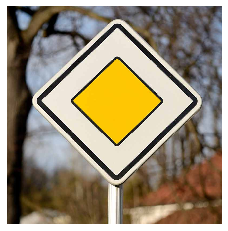

In [401]:
predict_sign('sign1.png', nn.Sequential(model, nn.Softmax(dim=1)), data.stats)

Stop, prob: 1.0


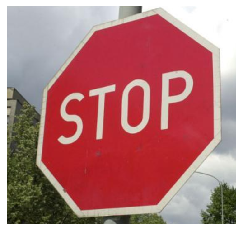

In [402]:
predict_sign('sign2.png', nn.Sequential(model, nn.Softmax(dim=1)), data.stats)

Speed_limit_60kmh, prob: 0.9999998807907104


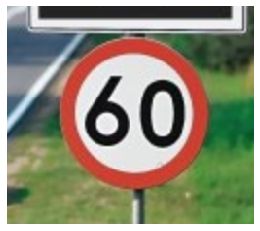

In [403]:
predict_sign('sign3.png', nn.Sequential(model, nn.Softmax(dim=1)), data.stats)

Roundabout_mandatory, prob: 0.9999998807907104


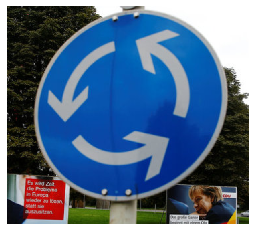

In [404]:
predict_sign('sign4.png', nn.Sequential(model, nn.Softmax(dim=1)), data.stats)

Road_work, prob: 1.0


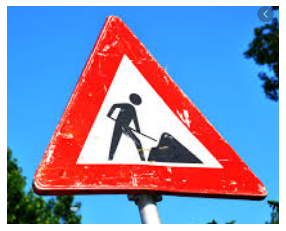

In [405]:
predict_sign('sign5.png', nn.Sequential(model, nn.Softmax(dim=1)), data.stats)

As we can see, model is pretty confident about its predictions on various well-formed images of the traffic signs. To finish up, we attach a couple of screenshots from the mobile app running the model. As we can see, the model is able to run in real-time (60-70 FPS) on mobile device. More details about the app are available in the repository's README.md file.

In [0]:
img_cv = cv2.imread('appScreen.png')
img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

(-0.5, 2903.5, 1839.5, -0.5)

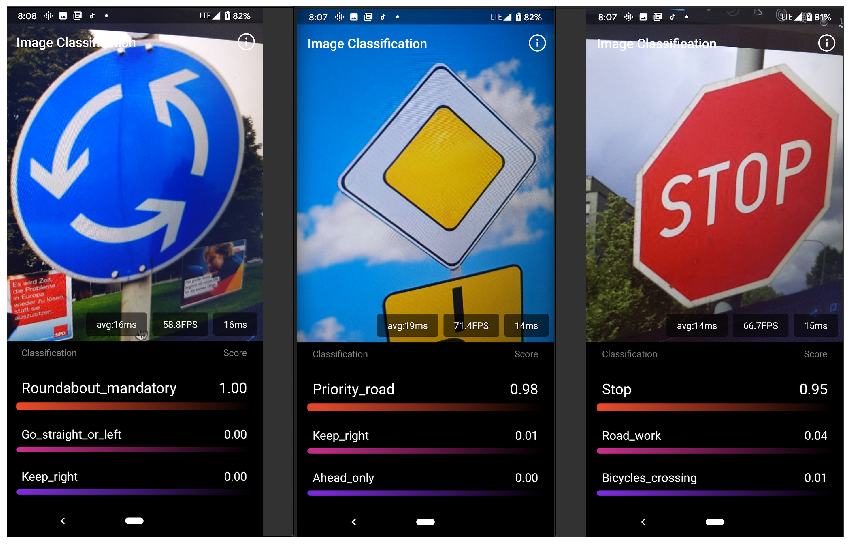

In [419]:
plt.figure(figsize=(15,10))
plt.imshow(img_cv)
plt.axis('off')